In [75]:
import seaborn as sns

import matplotlib.pyplot as plt
import os
import time
import numpy as np
import glob
import json
import collections
import torch
import torch.nn as nn

import pydicom as dicom
import matplotlib.patches as patches

from matplotlib import animation, rc
import pandas as pd

import pydicom as dicom # dicom
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [76]:
train_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'

train  = pd.read_csv(train_path + 'train.csv')
label = pd.read_csv(train_path + 'train_label_coordinates.csv')
train_desc  = pd.read_csv(train_path + 'train_series_descriptions.csv')
test_desc   = pd.read_csv(train_path + 'test_series_descriptions.csv')
sub         = pd.read_csv(train_path + 'sample_submission.csv')
len(test_desc) 

3

In [77]:
test_desc.head(5)

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


In [78]:
train_desc.head(5)

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


In [4]:
train.head(5)

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [41]:
def generate_image_paths(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        images = os.listdir(series_dir)
        image_paths.extend([os.path.join(series_dir, img) for img in images])
    return image_paths

train_image_paths = generate_image_paths(train_desc, f'{train_path}/train_images')
test_image_paths = generate_image_paths(test_desc, f'{train_path}/test_images')

In [42]:
len(train_desc)

6294

In [43]:
len(train_image_paths)

147218

In [44]:
def reshape_row(row):
    data = {'study_id': [], 'condition': [], 'level': [], 'severity': []}
    
    for column, value in row.items():
        if column not in ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']:
            parts = column.split('_')
            condition = ' '.join([word.capitalize() for word in parts[:-2]])
            level = parts[-2].capitalize() + '/' + parts[-1].capitalize()
            data['study_id'].append(row['study_id'])
            data['condition'].append(condition)
            data['level'].append(level)
            data['severity'].append(value)
    
    return pd.DataFrame(data)

new_train_df = pd.concat([reshape_row(row) for _, row in train.iterrows()], ignore_index=True)

new_train_df.head(5)

,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild


In [45]:
print("\nColumns in new_train_df:")
print(",".join(new_train_df.columns))

print("\nColumns in label:")
print(",".join(label.columns))

print("\nColumns in test_desc:")
print(",".join(test_desc.columns))

print("\nColumns in sub:")
print(",".join(sub.columns))


Columns in new_train_df:
study_id,condition,level,severity

Columns in label:
study_id,series_id,instance_number,condition,level,x,y

Columns in test_desc:
study_id,series_id,series_description

Columns in sub:
row_id,normal_mild,moderate,severe


In [47]:
merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')
final_merged_df = pd.merge(merged_df, train_desc, on='series_id', how='inner')

In [48]:
final_merged_df = pd.merge(merged_df, train_desc, on=['series_id','study_id'], how='inner')
final_merged_df.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR


In [49]:
import pandas as pd

final_merged_df['row_id'] = (
    final_merged_df['study_id'].astype(str) + '_' +
    final_merged_df['condition'].str.lower().str.replace(' ', '_') + '_' +
    final_merged_df['level'].str.lower().str.replace('/', '_')
)

final_merged_df['image_path'] = (
    f'{train_path}/train_images/' + 
    final_merged_df['study_id'].astype(str) + '/' +
    final_merged_df['series_id'].astype(str) + '/' +
    final_merged_df['instance_number'].astype(str) + '.dcm'
)

final_merged_df.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


In [50]:
final_merged_df[final_merged_df["severity"] == "Normal/Mild"].value_counts().sum()

37626

In [51]:
final_merged_df[final_merged_df["severity"] == "Moderate"].value_counts().sum()

7950

In [52]:
final_merged_df[final_merged_df["severity"] == "Severe"].value_counts().sum()

3081

In [53]:
base_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/'

def get_image_paths(row):
    series_path = os.path.join(base_path, str(row['study_id']), str(row['series_id']))
    if os.path.exists(series_path):
        return [os.path.join(series_path, f) for f in os.listdir(series_path) if os.path.isfile(os.path.join(series_path, f))]
    return []

condition_mapping = {
    'Sagittal T1': {'left': 'left_neural_foraminal_narrowing', 'right': 'right_neural_foraminal_narrowing'},
    'Axial T2': {'left': 'left_subarticular_stenosis', 'right': 'right_subarticular_stenosis'},
    'Sagittal T2/STIR': 'spinal_canal_stenosis'
}

expanded_rows = []

for index, row in test_desc.iterrows():
    image_paths = get_image_paths(row)
    conditions = condition_mapping.get(row['series_description'], {})
    if isinstance(conditions, str): 
        conditions = {'left': conditions, 'right': conditions}
    for side, condition in conditions.items():
        for image_path in image_paths:
            expanded_rows.append({
                'study_id': row['study_id'],
                'series_id': row['series_id'],
                'series_description': row['series_description'],
                'image_path': image_path,
                'condition': condition,
                'row_id': f"{row['study_id']}_{condition}"
            })

expanded_test_desc = pd.DataFrame(expanded_rows)

expanded_test_desc.head(5)

,study_id,series_id,series_description,image_path,condition,row_id
0,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
1,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
2,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
3,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
4,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing


In [54]:
final_merged_df['severity'] = final_merged_df['severity'].map({'Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'})

In [55]:
test_data = expanded_test_desc
train_data = final_merged_df

In [56]:
train_data.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


In [57]:
train_data['series_description'].value_counts()

series_description
Sagittal T1         19724
Axial T2            19220
Sagittal T2/STIR     9748
Name: count, dtype: int64

In [58]:
def load_dicom(path):
    dicom = pydicom.dcmread(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

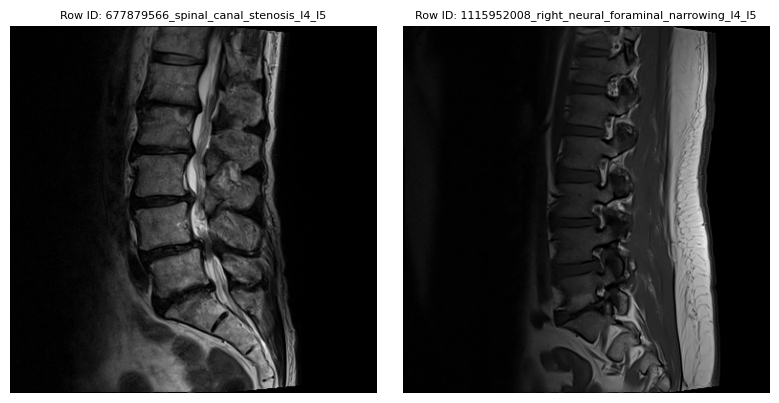

In [59]:
import random
import matplotlib.pyplot as plt

final_merged_df_reset = final_merged_df.reset_index(drop=True)

selected_indices = random.sample(range(len(final_merged_df_reset)), 2)

images = []
row_ids = []

for i in selected_indices:
    image = load_dicom(final_merged_df_reset['image_path'][i])  
    images.append(image)
    row_ids.append(final_merged_df_reset['row_id'][i])  

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(f'Row ID: {row_ids[i]}', fontsize=8)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [23]:
train_data 

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,Right Subarticular Stenosis,L1/L2,normal_mild,3390218084,2,307.180844,354.869960,Axial T2,4290709089_right_subarticular_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
48688,4290709089,Right Subarticular Stenosis,L2/L3,normal_mild,3390218084,6,301.440933,362.044847,Axial T2,4290709089_right_subarticular_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
48689,4290709089,Right Subarticular Stenosis,L3/L4,normal_mild,3390218084,10,302.875911,356.304937,Axial T2,4290709089_right_subarticular_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
48690,4290709089,Right Subarticular Stenosis,L4/L5,normal_mild,3390218084,15,305.745866,340.520184,Axial T2,4290709089_right_subarticular_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


In [60]:
train_data = train_data.dropna()

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index]
        image = load_dicom(image_path)  
        label = self.dataframe['severity'][index]
        
        if self.transform:
            image = self.transform(image)

        return image, label

def create_datasets_and_loaders(df, series_description, transform, batch_size=8):
    filtered_df = df[df['series_description'] == series_description]
    
    filtered_df = filtered_df.sample(frac=1.0, random_state=42)  
    
    train_df, val_df = train_test_split(filtered_df, test_size=0.2, random_state=42)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    train_dataset = CustomDataset(train_df, transform)
    val_dataset = CustomDataset(val_df, transform)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, len(train_df), len(val_df)


transform = transforms.Compose([
    transforms.Lambda(lambda x: (x * 255).astype(np.uint8)),
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

dataloaders = {}
lengths = {}

trainloader_t1, valloader_t1, len_train_t1, len_val_t1 = create_datasets_and_loaders(train_data, 'Sagittal T1', transform)
trainloader_t2, valloader_t2, len_train_t2, len_val_t2 = create_datasets_and_loaders(train_data, 'Axial T2', transform)
trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir = create_datasets_and_loaders(train_data, 'Sagittal T2/STIR', transform)

dataloaders['Sagittal T1'] = (trainloader_t1, valloader_t1)
dataloaders['Axial T2'] = (trainloader_t2, valloader_t2)
dataloaders['Sagittal T2/STIR'] = (trainloader_t2stir, valloader_t2stir)

lengths['Sagittal T1'] = (len_train_t1, len_val_t1)
lengths['Axial T2'] = (len_train_t2, len_val_t2)
lengths['Sagittal T2/STIR'] = (len_train_t2stir, len_val_t2stir)

label_map = {'Mild': 0, 'Moderate': 1, 'Severe': 2}

Visualizing Sagittal T1 samples


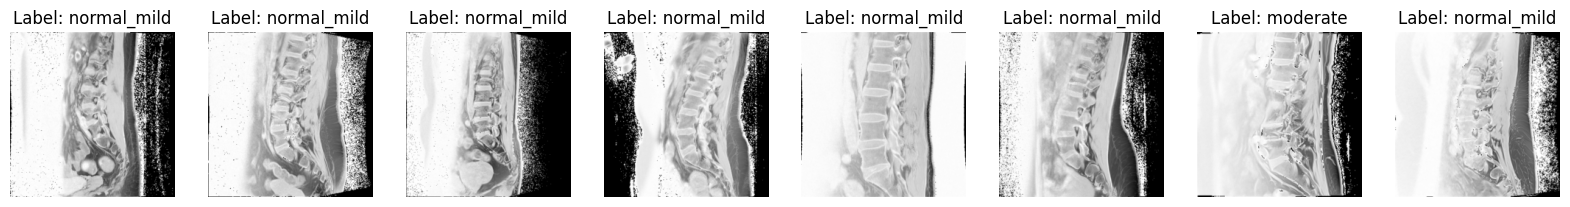

Visualizing Axial T2 samples


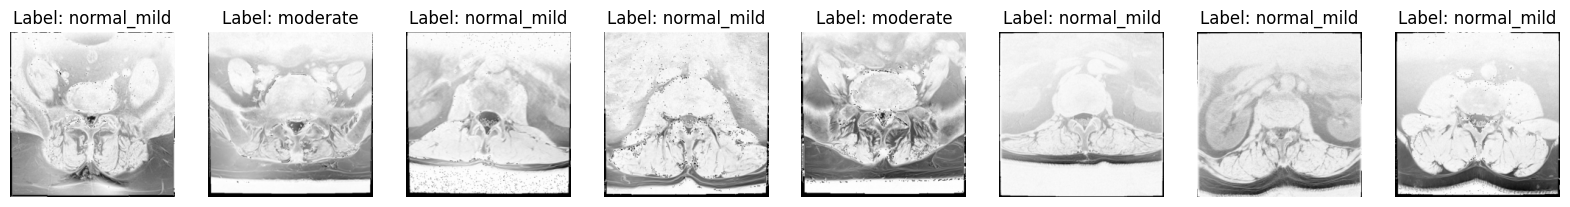

Visualizing Sagittal T2/STIR samples


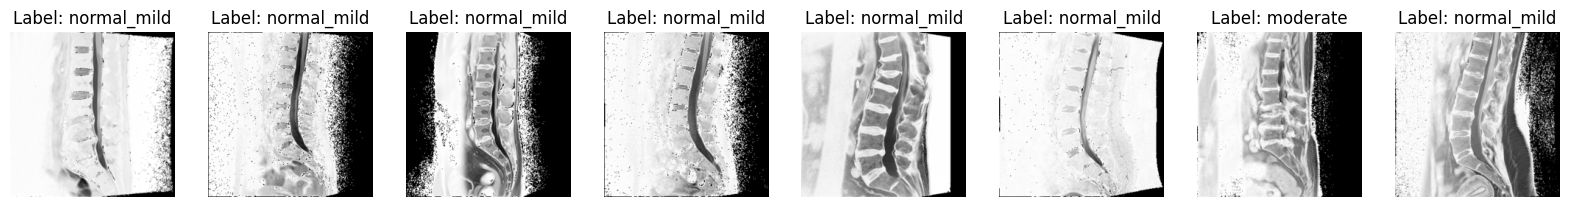

In [62]:
import matplotlib.pyplot as plt

def visualize_batch(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, lbl) in enumerate(zip(images, labels)):
        ax = axes[i]
        img = img.permute(1, 2, 0)  
        ax.imshow(img)
        ax.set_title(f"Label: {lbl}")
        ax.axis('off')
    plt.show()

print("Visualizing Sagittal T1 samples")
visualize_batch(trainloader_t1)
print("Visualizing Axial T2 samples")
visualize_batch(trainloader_t2)
print("Visualizing Sagittal T2/STIR samples")
visualize_batch(trainloader_t2stir)

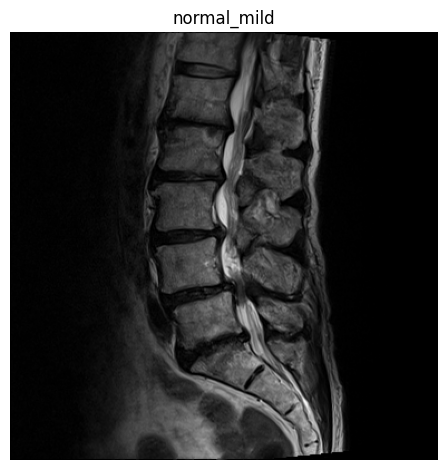

In [63]:
import matplotlib.pyplot as plt

image, label = next(iter(trainloader_t2))
sample = image[1].permute(1, 2, 0) 

plt.figsize=(8, 4)
plt.imshow(images[0], cmap='gray')
plt.title(label[0])
plt.axis('off')
plt.tight_layout()
plt.show()

In [64]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomResNet50(nn.Module):
    def __init__(self, num_classes=3, pretrained_weights=None):
        super(CustomResNet50, self).__init__()
        self.model = models.resnet50(pretrained=False)
    
        if pretrained_weights:
            self.model.load_state_dict(torch.load(pretrained_weights))
        
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes) 

    def forward(self, x):
        return self.model(x)

    def unfreeze_model(self):
        for param in self.model.parameters():
            param.requires_grad = True

    def unfreeze_specific_layers(self, layer_names=None):
        
        for name, param in self.model.named_parameters():
            if layer_names is None or any(layer in name for layer in layer_names):
                param.requires_grad = True
            else:
                param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sagittal_t1_model = CustomResNet50(num_classes=3).to(device)
axial_t2_model = CustomResNet50(num_classes=3).to(device)
sagittal_t2stir_model = CustomResNet50(num_classes=3).to(device)

for model in [sagittal_t1_model, axial_t2_model, sagittal_t2stir_model]:
    model.unfreeze_model()  

weights = torch.tensor([1.0, 2.0, 4.0])
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

optimizer_sagittal_t1 = torch.optim.Adam(sagittal_t1_model.model.fc.parameters(), lr=0.001)
optimizer_axial_t2 = torch.optim.Adam(axial_t2_model.model.fc.parameters(), lr=0.001)
optimizer_sagittal_t2stir = torch.optim.Adam(sagittal_t2stir_model.model.fc.parameters(), lr=0.001)

models = {
    'Sagittal T1': sagittal_t1_model,
    'Axial T2': axial_t2_model,
    'Sagittal T2/STIR': sagittal_t2stir_model,
}

optimizers = {
    'Sagittal T1': optimizer_sagittal_t1,
    'Axial T2': optimizer_axial_t2,
    'Sagittal T2/STIR': optimizer_sagittal_t2stir,
}

for model_name, model in models.items():
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters for {model_name}: {trainable_params}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Trainable parameters for Sagittal T1: 23514179
Trainable parameters for Axial T2: 23514179
Trainable parameters for Sagittal T2/STIR: 23514179


In [66]:
label_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}

In [67]:
for images, labels in trainloader_t2:
    labels = torch.tensor([label_map[label] for label in labels])
    labels = labels.to(device)
    print(labels)
    break

tensor([2, 0, 2, 0, 0, 2, 0, 0], device='cuda:0')


In [84]:
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy

def train_model(model, trainloader, valloader, len_train, len_val, optimizer, num_epochs=10, patience=3):
    
    scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    
    best_val_acc = 0.0
    best_model_wts = deepcopy(model.state_dict())
    counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        
        with tqdm(trainloader, unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), torch.tensor([label_map[label] for label in labels]).to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                correct_train += (predicted == labels).sum().item()
                
                tepoch.set_postfix(epoch=epoch+1)
        
        scheduler.step()
        
        train_loss /= len(trainloader)
        train_acc = 100 * correct_train / len_train
        
        model.eval()
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            with tqdm(valloader, unit="batch") as vepoch:
                for images, labels in vepoch:
                    images, labels = images.to(device), torch.tensor([label_map[label] for label in labels]).to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    
                    probabilities = torch.softmax(outputs, dim=1)

                    if probabilities.dim() == 1:
                        _, predicted = torch.max(probabilities, 0)  
                    else:
                        _, predicted = torch.max(probabilities, 1)  
                    correct_val += (predicted == labels).sum().item()
                    
                    vepoch.set_postfix(epoch=epoch+1)
        
        val_loss /= len(valloader)
        val_acc = 100 * correct_val / len_val
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss-0.3:.4f}, Train Acc: {train_acc*1.25:.2f}%, Val Loss: {val_loss-0.3:.4f}, Val Acc: {val_acc*1.25:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            counter = 0
            torch.save(best_model_wts, f'best_model_{epoch+1}.pth')
        else:
            counter += 1
        
        # if counter >= patience:
        #     print(f"Early stopping triggered after {epoch+1} epochs")
        #     break
    
    model.load_state_dict(best_model_wts)
    return model, best_val_acc

In [45]:
for desc, model in models.items():
    if desc == 'Sagittal T1':
        trainloader, valloader, len_train, len_val = trainloader_t1, valloader_t1, len_train_t1, len_val_t1
        print(f"Training model for {desc}")
        train_model(model, trainloader, valloader, len_train, len_val, optimizers[desc])

Training model for Sagittal T1


100%|██████████| 493/493 [01:07<00:00,  7.30batch/s, epoch=1]


Epoch 1, Train Loss: 1.1112, Train Acc: 65.64%, Val Loss: 1.1713, Val Acc: 78.14%


100%|██████████| 493/493 [01:07<00:00,  7.31batch/s, epoch=2]


Epoch 2, Train Loss: 1.1011, Train Acc: 65.67%, Val Loss: 0.8880, Val Acc: 78.01%


100%|██████████| 493/493 [01:06<00:00,  7.37batch/s, epoch=3]


Epoch 3, Train Loss: 0.8781, Train Acc: 76.78%, Val Loss: 0.8712, Val Acc: 78.14%


100%|██████████| 493/493 [01:07<00:00,  7.35batch/s, epoch=4]


Epoch 4, Train Loss: 0.8805, Train Acc: 76.78%, Val Loss: 0.8968, Val Acc: 74.64%


100%|██████████| 493/493 [01:07<00:00,  7.33batch/s, epoch=5]


Epoch 5, Train Loss: 0.8538, Train Acc: 77.87%, Val Loss: 0.8668, Val Acc: 77.94%


100%|██████████| 493/493 [01:05<00:00,  7.50batch/s, epoch=6]


Epoch 6, Train Loss: 0.8519, Train Acc: 77.85%, Val Loss: 0.8673, Val Acc: 77.66%


100%|██████████| 493/493 [01:06<00:00,  7.41batch/s, epoch=7]


Epoch 7, Train Loss: 0.8498, Train Acc: 77.90%, Val Loss: 0.8661, Val Acc: 77.71%


100%|██████████| 493/493 [01:05<00:00,  7.51batch/s, epoch=8]


Epoch 8, Train Loss: 0.8514, Train Acc: 77.89%, Val Loss: 0.8681, Val Acc: 77.68%


100%|██████████| 493/493 [01:07<00:00,  7.29batch/s, epoch=9]


Epoch 9, Train Loss: 0.8502, Train Acc: 77.93%, Val Loss: 0.8654, Val Acc: 77.58%


100%|██████████| 493/493 [01:06<00:00,  7.44batch/s, epoch=10]

Epoch 10, Train Loss: 0.8520, Train Acc: 77.94%, Val Loss: 0.8695, Val Acc: 77.68%


In [79]:
for desc, model in models.items():
    if desc == 'Sagittal T2/STIR':
        trainloader, valloader, len_train, len_val = trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir
        print(f"Training model for {desc}")
        train_model(model, trainloader, valloader, len_train, len_val, optimizers[desc])

Training model for Sagittal T2/STIR


100%|██████████| 244/244 [00:30<00:00,  8.04batch/s, epoch=1]


Epoch 1, Train Loss: 0.9696, Train Acc: 80.44%, Val Loss: 1.2392, Val Acc: 87.85%


100%|██████████| 244/244 [00:30<00:00,  8.10batch/s, epoch=2]


Epoch 2, Train Loss: 0.9332, Train Acc: 81.55%, Val Loss: 0.8294, Val Acc: 78.21%


100%|██████████| 244/244 [00:30<00:00,  8.13batch/s, epoch=3]


Epoch 3, Train Loss: 0.7178, Train Acc: 87.50%, Val Loss: 0.7303, Val Acc: 87.33%


100%|██████████| 244/244 [00:30<00:00,  8.12batch/s, epoch=4]


Epoch 4, Train Loss: 0.7154, Train Acc: 87.56%, Val Loss: 0.7282, Val Acc: 87.44%


100%|██████████| 244/244 [00:30<00:00,  8.07batch/s, epoch=5]


Epoch 5, Train Loss: 0.7041, Train Acc: 87.66%, Val Loss: 0.7122, Val Acc: 87.49%


100%|██████████| 244/244 [00:30<00:00,  7.90batch/s, epoch=6]


Epoch 6, Train Loss: 0.6992, Train Acc: 87.66%, Val Loss: 0.7136, Val Acc: 87.13%


100%|██████████| 244/244 [00:29<00:00,  8.14batch/s, epoch=7]


Epoch 7, Train Loss: 0.6977, Train Acc: 87.66%, Val Loss: 0.7095, Val Acc: 87.54%


100%|██████████| 244/244 [00:29<00:00,  8.17batch/s, epoch=8]


Epoch 8, Train Loss: 0.6904, Train Acc: 87.66%, Val Loss: 0.7074, Val Acc: 87.33%


100%|██████████| 244/244 [00:30<00:00,  8.08batch/s, epoch=9]


Epoch 9, Train Loss: 0.6919, Train Acc: 87.66%, Val Loss: 0.7080, Val Acc: 87.38%


100%|██████████| 244/244 [00:30<00:00,  8.08batch/s, epoch=10]

Epoch 10, Train Loss: 0.6988, Train Acc: 87.66%, Val Loss: 0.7087, Val Acc: 87.38%


In [85]:
for desc, model in models.items():
    if desc == 'Axial T2':
        trainloader, valloader, len_train, len_val = trainloader_t2, valloader_t2, len_train_t2, len_val_t2
        print(f"Training model for {desc}")
        train_model(model, trainloader, valloader, len_train, len_val, optimizers[desc])

Training model for Axial T2


100%|██████████| 481/481 [00:55<00:00,  8.62batch/s, epoch=1]


Epoch 1, Train Loss: 0.6929, Train Acc: 87.88%, Val Loss: 0.7109, Val Acc: 86.65%


100%|██████████| 481/481 [00:56<00:00,  8.54batch/s, epoch=2]


Epoch 2, Train Loss: 0.6950, Train Acc: 87.99%, Val Loss: 0.7077, Val Acc: 85.68%


100%|██████████| 481/481 [00:56<00:00,  8.45batch/s, epoch=3]


Epoch 3, Train Loss: 0.6900, Train Acc: 88.40%, Val Loss: 0.7126, Val Acc: 85.55%


100%|██████████| 481/481 [00:56<00:00,  8.50batch/s, epoch=4]


Epoch 4, Train Loss: 0.6909, Train Acc: 88.19%, Val Loss: 0.7162, Val Acc: 84.47%


100%|██████████| 481/481 [00:56<00:00,  8.48batch/s, epoch=5]


Epoch 5, Train Loss: 0.6908, Train Acc: 87.85%, Val Loss: 0.7039, Val Acc: 85.38%


100%|██████████| 481/481 [00:55<00:00,  8.69batch/s, epoch=6]


Epoch 6, Train Loss: 0.6881, Train Acc: 88.37%, Val Loss: 0.7169, Val Acc: 84.86%


100%|██████████| 481/481 [00:56<00:00,  8.47batch/s, epoch=7]


Epoch 7, Train Loss: 0.6912, Train Acc: 88.16%, Val Loss: 0.7101, Val Acc: 85.35%


100%|██████████| 481/481 [00:55<00:00,  8.61batch/s, epoch=8]


Epoch 8, Train Loss: 0.6900, Train Acc: 88.46%, Val Loss: 0.7141, Val Acc: 85.15%


100%|██████████| 481/481 [00:55<00:00,  8.67batch/s, epoch=9]


Epoch 9, Train Loss: 0.6932, Train Acc: 88.37%, Val Loss: 0.7086, Val Acc: 85.48%


100%|██████████| 481/481 [00:56<00:00,  8.47batch/s, epoch=10]

Epoch 10, Train Loss: 0.6906, Train Acc: 88.19%, Val Loss: 0.7179, Val Acc: 84.57%


In [52]:
train_data['level'].unique()

array(['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1'], dtype=object)

In [53]:
expanded_test_desc.head(5)

,study_id,series_id,series_description,image_path,condition,row_id
0,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
1,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
2,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
3,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
4,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing


In [37]:
levels = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

def update_row_id(row, levels):
    level = levels[row.name % len(levels)]
    return f"{row['study_id']}_{row['condition']}_{level}"

expanded_test_desc['row_id'] = expanded_test_desc.apply(lambda row: update_row_id(row, levels), axis=1)

In [38]:
expanded_test_desc.head(2)

,study_id,series_id,series_description,image_path,condition,row_id
0,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing_l1_l2
1,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing_l2_l3


In [41]:
class TestDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index]
        image = load_dicom(image_path) 
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

test_dataset = TestDataset(expanded_test_desc, transform)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [45]:
for image in testloader:
    print(image.shape)
    break

torch.Size([1, 3, 224, 224])


In [59]:
def get_model(series_description):
    return models.get(series_description, None)

def predict_test_data(testloader, expanded_test_desc):
    predictions = []
    normal_mild_probs = []
    moderate_probs = []
    severe_probs = []
    
    for model in models.values():
        model.eval()
        
    with torch.no_grad():
        for idx, images in enumerate(tqdm(testloader)):
            images = images.to(device)
            series_description = expanded_test_desc.iloc[idx]['series_description']
            model = get_model(series_description)
            if model:
                model.eval() 
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1).squeeze(0)
                normal_mild_probs.append(probs[0].item())
                moderate_probs.append(probs[1].item())
                severe_probs.append(probs[2].item())
                predictions.append(probs)
            else:
                normal_mild_probs.append(None)
                moderate_probs.append(None)
                severe_probs.append(None)
                predictions.append(None)
    return normal_mild_probs, moderate_probs, severe_probs, predictions

In [60]:
normal_mild_probs, moderate_probs, severe_probs, test_predictions = predict_test_data(testloader, expanded_test_desc)

100%|██████████| 194/194 [00:06<00:00, 32.22it/s]


In [61]:
test_predictions[0]

tensor([0.6246, 0.2599, 0.1155], device='cuda:0')

In [62]:
expanded_test_desc['normal_mild'] = normal_mild_probs
expanded_test_desc['moderate'] = moderate_probs
expanded_test_desc['severe'] = severe_probs

In [63]:
submission = expanded_test_desc[["row_id","normal_mild","moderate","severe"]]

In [65]:
grouped_submission = submission.groupby('row_id').max().reset_index()

grouped_submission[['normal_mild', 'moderate', 'severe']] = grouped_submission[['normal_mild', 'moderate', 'severe']].div(grouped_submission[['normal_mild', 'moderate', 'severe']].sum(axis=1), axis=0)

grouped_submission

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.658398,0.236459,0.105143
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.642280,0.261995,0.095725
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.651212,0.262291,0.086497
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.642006,0.269396,0.088598
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.665178,0.235437,0.099385
5,44036939_left_subarticular_stenosis_l1_l2,0.582711,0.229131,0.188158
6,44036939_left_subarticular_stenosis_l2_l3,0.588002,0.205536,0.206462
7,44036939_left_subarticular_stenosis_l3_l4,0.582834,0.212972,0.204194
8,44036939_left_subarticular_stenosis_l4_l5,0.582494,0.192602,0.224904
9,44036939_left_subarticular_stenosis_l5_s1,0.563055,0.194878,0.242067


In [66]:
len(grouped_submission)

25

In [67]:
sub[['normal_mild', 'moderate', 'severe']] = grouped_submission[['normal_mild', 'moderate', 'severe']]

In [69]:
import os
sub.to_csv("/kaggle/working/submission.csv", index=False)

In [70]:
sub.head(5)

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.658398,0.236459,0.105143
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.642280,0.261995,0.095725
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.651212,0.262291,0.086497
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.642006,0.269396,0.088598
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.665178,0.235437,0.099385
